In [11]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [ ]:
# !pip install matplotlib==3.1.1 # Issue with last version bar plots

In [26]:
import sys

sys.path.insert(0, "../")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display

from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d

from tqdm import tqdm_notebook

<IPython.core.display.Javascript object>

## Load data

In [2]:
# read data
X_train = np.load("../data/DOCC10_train/DOCC10_Xtrain.npy")
X_test = np.load("../data/DOCC10_test/DOCC10_Xtest.npy")
Y_train_df = pd.read_csv("../data/DOCC10_train/DOCC10_Ytrain.csv", index_col=0)

# Shift indexes
Y_train_df.index = Y_train_df.index - 20960

all_classes = list(set(Y_train_df.TARGET.values))

print("X train", X_train.shape, "Y_train", Y_train_df.shape, "X_test", X_test.shape)

X train (113120, 8192) Y_train (113120, 1) X_test (20960, 8192)


## Segment clicks 

In [3]:
def get_center(x_r):
    # Parameters
    cutoff = 10000
    win_size = 50
    gaussian_std = 5
    fs = 200000
    nyq = fs // 2
    order = 2
    normal_cutoff = cutoff / nyq

    # Butterworth highpass filter
    b, a = signal.butter(order, normal_cutoff, btype="high", analog=False)
    x_h = signal.filtfilt(b, a, x_r)

    # Wiener filter
    x_w = signal.wiener(x_h, mysize=win_size)

    # Gaussian filter
    x_g = gaussian_filter1d(np.abs(x_w), gaussian_std)

    # Argmax of the resulting signal
    center = x_g.argmax()

    return center

In [4]:
def show_centers(n_plots, classes):
    fig, axes = plt.subplots(
        n_plots, len(classes), figsize=(2 * len(classes), 2 * n_plots)
    )
    for j in range(len(classes)):
        X_sub = X_train[(Y_train_df == classes[j]).values.flatten()]
        axes[0, j].set_title(classes[j])
        for i in range(n_plots):
            idx = np.random.randint(len(X_sub))
            center = get_center(X_sub[idx])
            axes[i, j].plot(X_sub[idx])
            axes[i, j].axvline(x=center, color="red")
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
    plt.show()

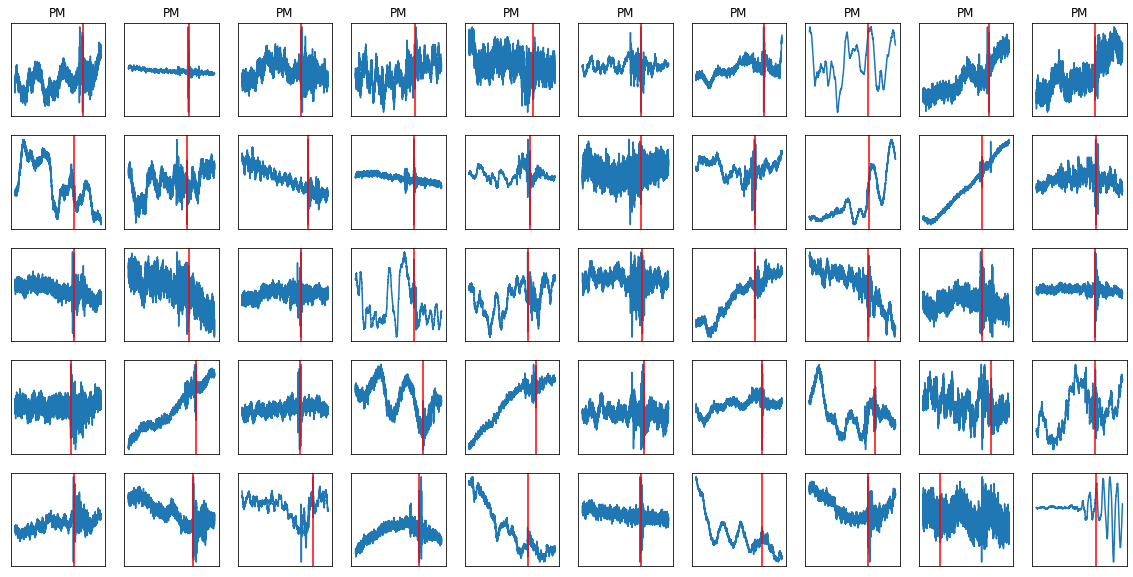

In [5]:
show_centers(5, ["PM"] * 10)

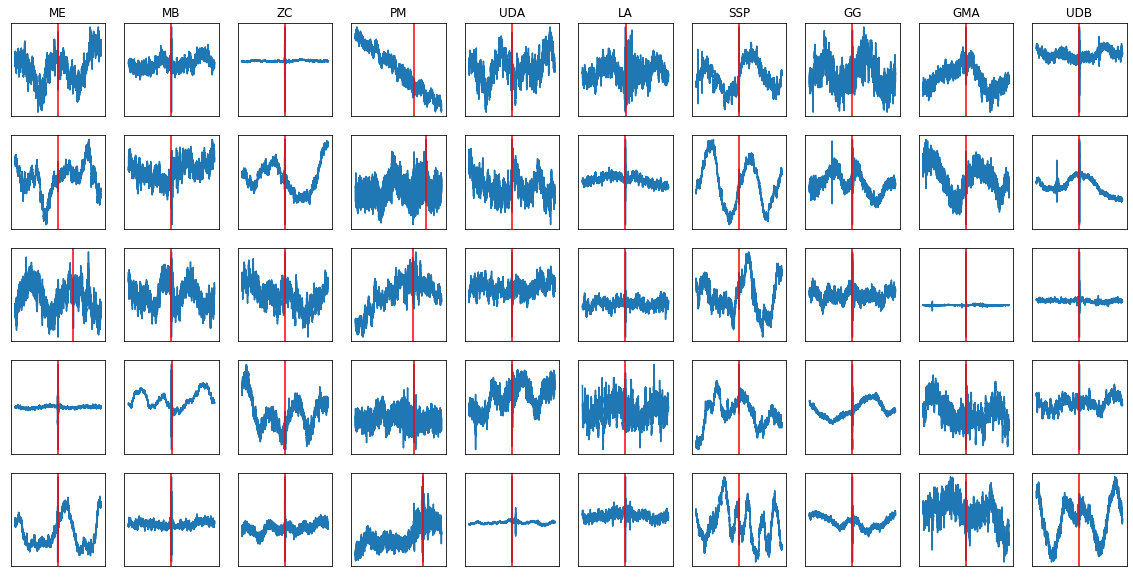

In [6]:
show_centers(5, all_classes)

In [7]:
def segment_clicks(x, cls=None, width=2 ** 8):
    T = len(x)
    assert width < T
    if cls == "PM":
        center = get_center(x)
    else:
        center = 2 ** 12
    if center - width // 2 < 0:
        min_t = 0
        max_t = width
    elif center + width // 2 >= T:
        min_t = -width
        max_t = T
    else:
        min_t = center - width // 2
        max_t = center + width // 2
    x_sub = x[min_t:max_t]
    assert len(x_sub) == width
    return x_sub

## Spectral features

### Feature: centered power spectrum bins

In [8]:
def get_power_spectrum(x, n_fft=64):
    n_fft = 64
    cutoff = 10000
    f_sampling = 200000
    window = signal.get_window(("gaussian", 30), n_fft)

    f, pspec = signal.welch(x, f_sampling, window, n_fft, scaling="spectrum")

    # Keep only freq > 10kHz
    pspec = pspec[f > cutoff]
    f = f[f > cutoff]
    return f, pspec

In [9]:
def show_temporal(x, vert=[]):
    plt.figure(figsize=(10, 5))
    plt.title("Signal")
    plt.plot(x)
    plt.yticks([])
    for v in vert:
        plt.axvline(x=v, color="red")
    plt.show()


def show_power_spectrum(frequencies, power_spectrum):
    plt.figure(figsize=(10, 5))
    plt.title("Power spectrum")
    N = len(frequencies)
    ind = np.arange(N)
    delta = frequencies[1] - frequencies[0]
    xlabels = (frequencies - delta / 2).astype(int)
    plt.bar(x=ind, height=power_spectrum)
    plt.xticks(ind, xlabels, rotation=45)
    plt.yticks([])
    plt.show()

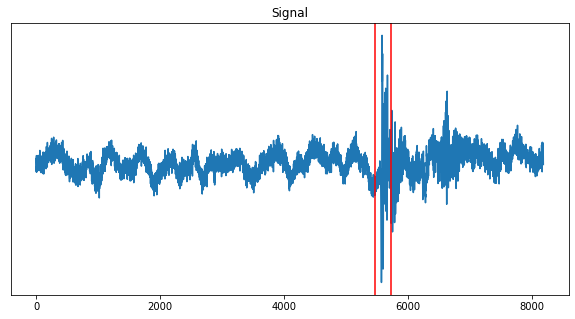

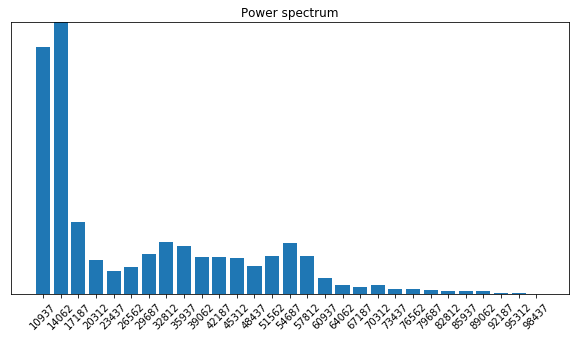

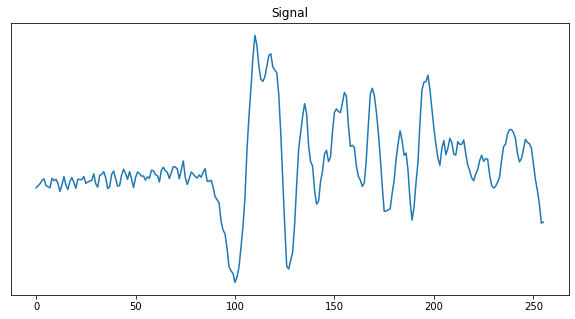

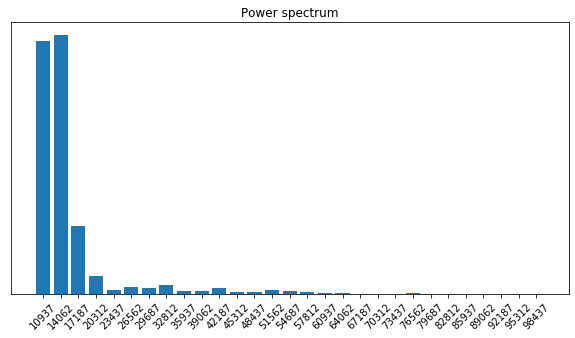

In [10]:
# Test
x_idx = 90496
x = X_train[x_idx]
x_cls = Y_train_df.loc[x_idx].TARGET
f, ps = get_power_spectrum(x, n_fft=64)
x_c = segment_clicks(x, cls=x_cls, width=2 ** 8)
f_c, ps_c = get_power_spectrum(x_c, n_fft=64)

show_temporal(x, [get_center(x) - 2 ** 7, get_center(x) + 2 ** 7])
show_power_spectrum(f, ps)
show_temporal(x_c)
show_power_spectrum(f_c, ps_c)

In [13]:
def show_power_spectrum_per_class(n_plots, classes):
    fig, axes = plt.subplots(
        n_plots, len(classes), figsize=(2 * len(classes), 2 * n_plots)
    )
    for j, cls in enumerate(classes):
        X_sub = X_train[(Y_train_df == classes[j]).values.flatten()]
        axes[0, j].set_title(classes[j])
        for i in range(n_plots):
            idx = np.random.randint(len(X_sub))
            x = X_sub[idx]
            x_c = segment_clicks(x, cls, width=2 ** 9)
            f_c, ps_c = get_power_spectrum(x_c, n_fft=64)
            # axes[i, j].plot(f_c, ps_c)
            axes[i, j].bar(x=1.5 * np.arange(len(f_c)), height=ps_c)
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
    plt.show()

<IPython.core.display.Javascript object>

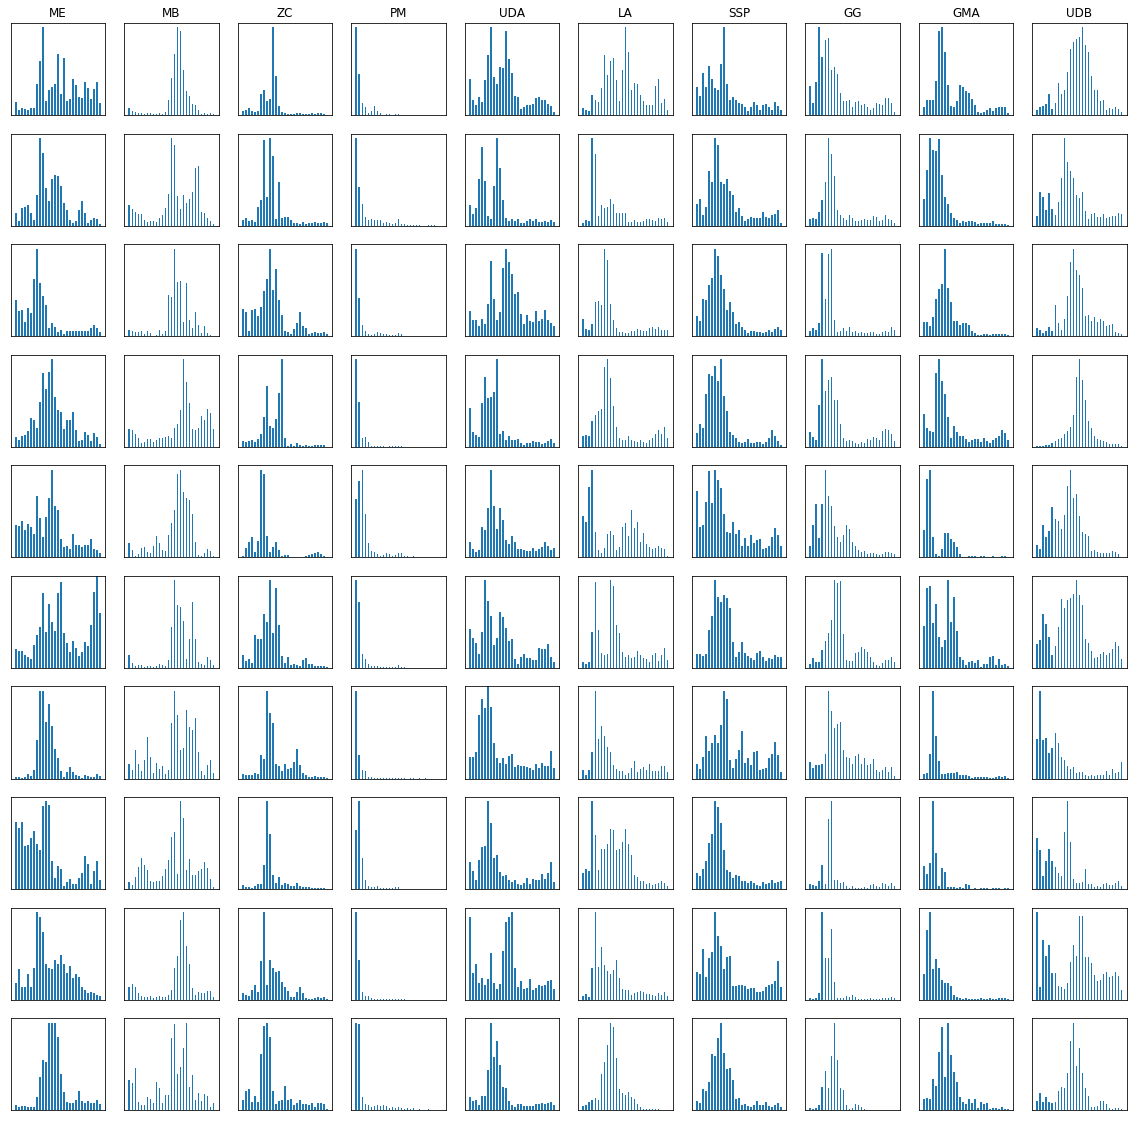

<IPython.core.display.Javascript object>

In [14]:
show_power_spectrum_per_class(10, all_classes)

### Feature: spectral width

In [15]:
def spectral_width(ps, ratio=0.5):
    pmax = ps.max()
    thresh = ratio * pmax
    width = (ps > thresh).sum()
    total = ps.sum()
    norm_width = width / total
    return norm_width

<IPython.core.display.Javascript object>

## Wavelets

In [52]:
import pywt
import scaleogram as scg

<IPython.core.display.Javascript object>

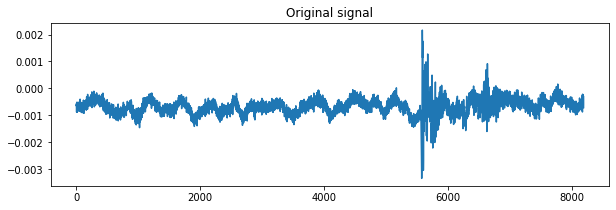

<IPython.core.display.Javascript object>

In [43]:
signal = X_train[90496]
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Original signal")
ax.plot(signal)
plt.show()

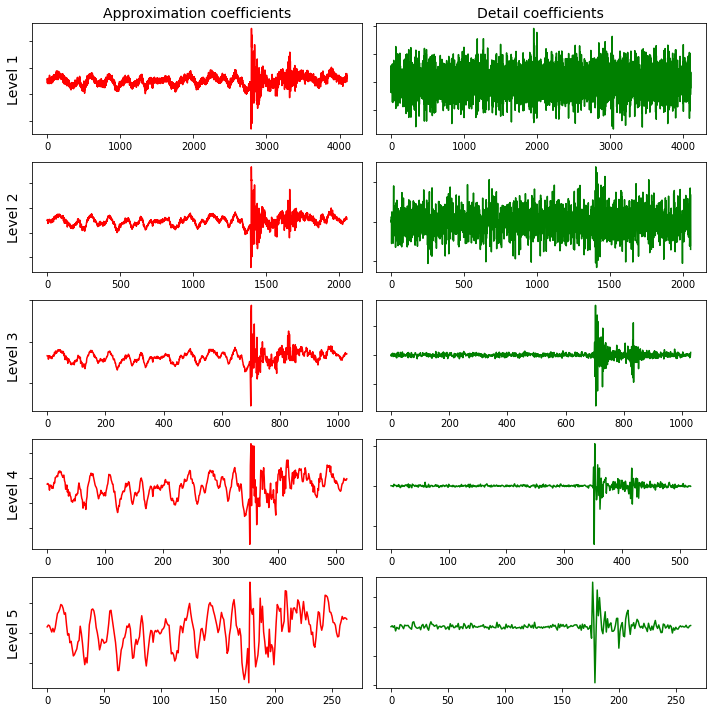

<IPython.core.display.Javascript object>

In [44]:
data = signal
waveletname = "sym5"

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, "r")
    axarr[ii, 1].plot(coeff_d, "g")
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

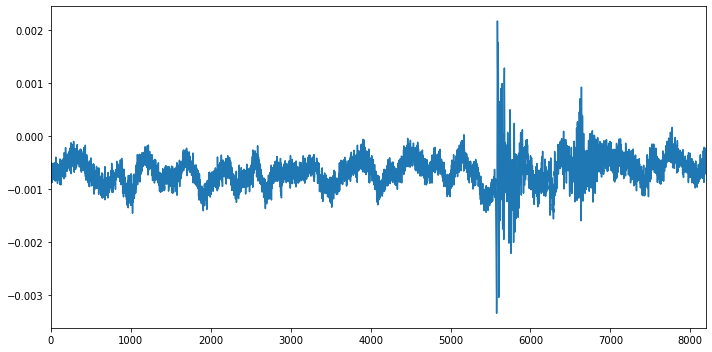

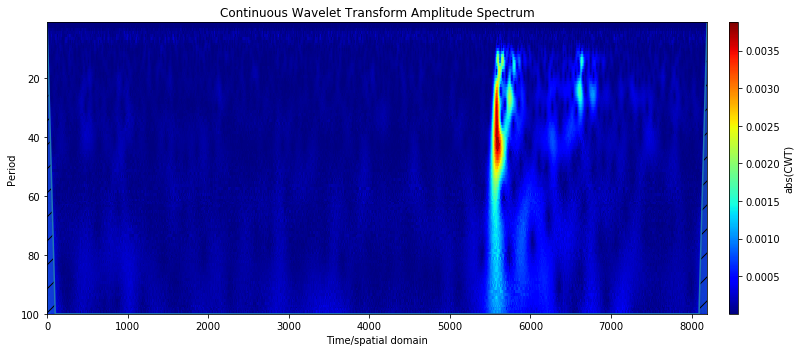

<IPython.core.display.Javascript object>

In [66]:
scg.set_default_wavelet("cmor1-1.5")

# Class PM
signal = X_train[90496]

# fs = 200000
#  T = 1.0 / fs
ns = len(signal)
time = np.arange(ns)

# and a range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, 100))

# plot the signal
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 5))
lines = ax1.plot(signal)
ax1.set_xlim(0, len(time))
fig1.tight_layout()

# and the scaleogram
ax2 = scg.cws(signal, scales=scales, figsize=(11.28, 5))
plt.tight_layout()

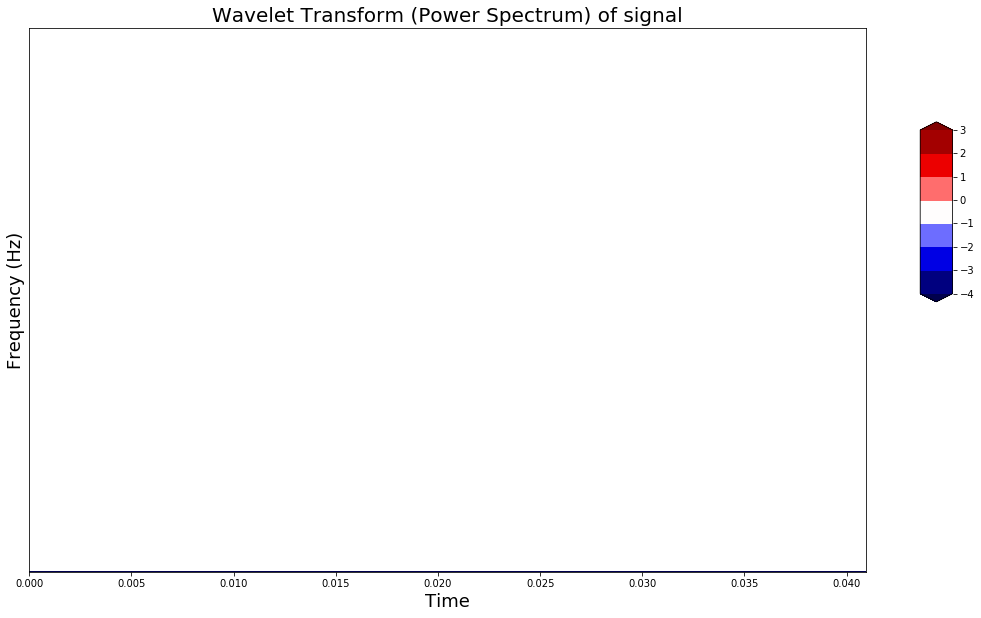

<IPython.core.display.Javascript object>

In [53]:
def plot_wavelet(
    time,
    signal,
    scales,
    waveletname="cmor1-1.5",
    cmap=plt.cm.seismic,
    title="Wavelet Transform (Power Spectrum) of signal",
    ylabel="Frequency (Hz)",
    xlabel="Time",
):

    fs = 200000
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, fs)
    power = np.abs(coefficients) ** 2
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)

    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(
        time,
        np.log2(frequencies),
        np.log2(power),
        contourlevels,
        extend="both",
        cmap=cmap,
    )

    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)

    yticks = 2 ** np.arange(
        np.ceil(np.log2(frequencies.min())), np.ceil(np.log2(frequencies.max()))
    )
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)

    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()


signal = X_train[90496]
N = len(signal)
fs = 200000
T = 1 / fs
time = np.arange(0, N) * T
scales = np.arange(1, 128)

plot_wavelet(time, signal, scales)

## Training a linear model

In [ ]:
Y = Y_train_df.TARGET.tolist()

In [ ]:
def build_ps_features():
    n_samples = X_train.shape[0]
    n_feats = 29 + 1
    X = np.zeros((n_samples, n_feats), dtype=np.float32)
    for i in tqdm_notebook(range(n_samples)):
        # Segment the click
        x = segment_clicks(X_train[i], cls=Y[i], width=2 ** 8)
        # Compute its power spectrum
        _, ps = get_power_spectrum(x, n_fft=64)
        # Divide it by Pmax
        ps = ps / ps.max()
        # Add the spectral width
        sw = spectral_width(ps)
        X[i, 0:29] = ps
        X[i, 29:] = sw
    return X

In [ ]:
X = build_ps_features()
print(X.shape)

In [ ]:
# !pip install --upgrade sklearn # requires scikit learn 0.22
from sklearn.preprocessing import StandardScaler, Normalizer, FunctionTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    plot_confusion_matrix,
    classification_report,
)

In [ ]:
# Stratified split
X_spec_train, X_spec_val, Y_train, Y_val = train_test_split(
    X, Y, stratify=Y, test_size=0.15
)
print(f"Train size: {len(X_spec_train)}, val size: {len(X_spec_val)}")

In [ ]:
def normalize(X_un_train, X_un_val, norm="unit"):
    if norm == "standard":
        scaler_cls = StandardScaler()
    elif norm == "unit":
        scaler_cls = Normalizer()
    else:
        scaler_cls = FunctionTransformer()  # Identity

    scaler = scaler_cls.fit(X_spec_train)

    X_sc_train = scaler.transform(X_spec_train)
    X_sc_val = scaler.transform(X_spec_val)
    return X_sc_train, X_sc_val

In [ ]:
# Scaling the data
norm = None  # "unit"

X_sc_spec_train, X_sc_spec_val = normalize(X_spec_train, X_spec_val, norm)

In [ ]:
# C_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# for C in C_list:
#     # Logistic regression
#     model = LogisticRegression(
#         C=C,
#         verbose=0,
#         solver="lbfgs",
#         max_iter=5000,
#         multi_class="multinomial",
#         random_state=0,
#         # tol=0.0001,
#     )
#     model.fit(X_sc_spec_train, Y_train)

#     # Val set
#     train_acc = model.score(X_sc_spec_train, Y_train)
#     val_acc = model.score(X_sc_spec_val, Y_val)
#     print("C:", C)
#     print(f"Train acc: {train_acc:.4f}")
#     print(f"Val acc: {val_acc:.4f}")

In [ ]:
# Logistic regression
model = LogisticRegression(
    C=50,
    verbose=1,
    solver="lbfgs",
    max_iter=5000,
    multi_class="multinomial",
    random_state=0,
    tol=0.0001,
)
model.fit(X_sc_spec_train, Y_train)

In [ ]:
# Val set
train_acc = model.score(X_sc_spec_train, Y_train)
val_acc = model.score(X_sc_spec_val, Y_val)

print(f"Train acc: {train_acc:.4f}")
print(f"Val acc: {val_acc:.4f}")

In [ ]:
print("Validation")
print(classification_report(Y_val, model.predict(X_sc_spec_val)))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("Confusion matrix")
plot_confusion_matrix(
    model, X_sc_spec_val, Y_val, cmap=plt.cm.Blues, normalize="true", ax=ax
)

Best: 0.64 with C=50 and unit